# Exploring and modelling Obesity Dataset

This Notebook explores the *Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico*[1] published on the University of California Irvine Machine Learning Repository ([link to the dataset](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+)). "ScienceDirect" provides free access to the corresponding [paper](https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub).

The dataset has 2111 records and 17 features. The records are labeled with the class variable "NObesity" (Obesity Level) that allows classification in 7 groups: "Insufficient Weight", "Normal Weight", "Overweight Level I", "Overweight Level II", "Obesity Type I", "Obesity Type II" and "Obesity Type III". The dataset authors note that 23% of the records were collected directly from users through a web platform, and the remaining 77% were generated synthetically with Weka tool and SMOTE filter.

Eating habits, physical activity, and genes are factors which affect person's obesity predisposition. The task here is to explore the dataset, and to find a decent model that would be capable to tell if someone is overweight or obese, or his or her body fits into the normal (health) range. On the other hand, an attempt was made to cluster the data based on all features (predictors). Both - classification and clustering - tasks are described after data exploration.

#### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.cluster import KMeans

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
import scikitplot as skplt

## I. Load data

The original data are provided in a `csv` file. It is loaded and stored in `obesity_data`. The first five rows are displayed below.

In [5]:
obesity_data = pd.read_csv("../input/obesity-levels/ObesityDataSet_raw_and_data_sinthetic.csv")

In [6]:
obesity_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


A brief check confirms the dataset has 2111 rows and 17 columns.

In [7]:
obesity_data.shape

(2111, 17)

## II. Exploratory Data Analysis

The output below shows that there are not missing values in the DataFrame; half of the features hold numeric (float64) values, and the other half - categorical ones. All are further explored in this Chapter. In general, the dataset is tidy, hence data cleaning was not neccessary.

In [8]:
obesity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

### II. 1. Explore Features

As mentioned earlier, part of the data were collected thought an online survey. Respondents had several options to answer each question. Features hold information gathered for each particular question and the corresponding possible answers. These are described and explored below.

Counting and visualizing categorical variables is wrapped in a function for avoiding repeated operations. The first plot shows the number of men and women in the dataset.

In [9]:
def count_values(dataset, cat_variable, order = None):
    """
    Function: Counts values in each category and displays them on a plot.
    
    Parameters: Dataset, category feature, and order of appearance (order is optional).
    """
    ax = sns.countplot(x = cat_variable, data = dataset, palette = "Blues_r", order = order)
    for p in ax.patches:
        ax.annotate(f"\n{p.get_height()}", (p.get_x()+0.2, p.get_height()), 
                    ha = "center", va = "top", color = "white", size = 10)
    
    plt.title(f"Number of items in each {cat_variable} category")
    plt.show()

#### Gender

There are almost an equal number of females and males in the dataset. Data is available for slightly more men than women but this does not make it imbalanced.

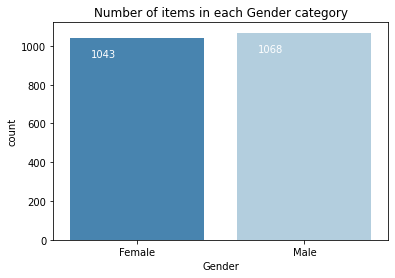

In [10]:
count_values(obesity_data, "Gender")

#### Age

Computing and visualizing distribution of continuous values is wrapped in a function, too. It displays not only data distribution but also its mean and median.

In [11]:
def plot_distribution(dataset, feature):
    """
    Function: Computes and displays distribution of features with continuous values; plots their mean and median.
    
    Parameters: Dataset and feature with continuous values.
    """
    plt.hist(dataset[feature], bins = "fd")
    
    plt.axvline(dataset[feature].mean(), color = "red", label = "mean")
    plt.axvline(dataset[feature].median(), color = "orange", label = "median")
    
    plt.xlabel(f"{feature}")
    plt.ylabel("Count")
    plt.legend()
    plt.title(f"Distribution of values in {feature}")
    plt.show()

The youngest person in the dataset is 14 years old, and the oldest one - 61 years of age. Values in this column are not normally distributed; the historgram is positively skewed with mean (24.31) and median (22.78) closer to the lower bound.

In [12]:
obesity_data["Age"].describe()

count    2111.000000
mean       24.312600
std         6.345968
min        14.000000
25%        19.947192
50%        22.777890
75%        26.000000
max        61.000000
Name: Age, dtype: float64

In [13]:
obesity_data["Age"].median()

22.77789

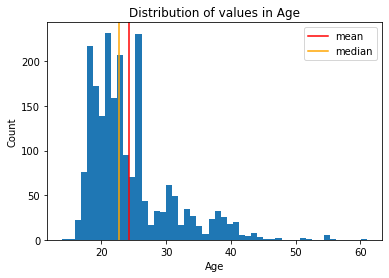

In [14]:
plot_distribution(obesity_data, "Age")

#### Height

Obesity is determined by computing the `Body mass index`. It is a function of person's height and weight. The exact formula is $Body mass index = \frac{Weight}{Height * Height}$. Thus, height is an important element for determining obesity. 

Distribution of height values is plotted below. Most people are 1.60 m - 1.85 m tall. Both mean and median values are around 1.70. Still, height values do not seem to be normally distributed.

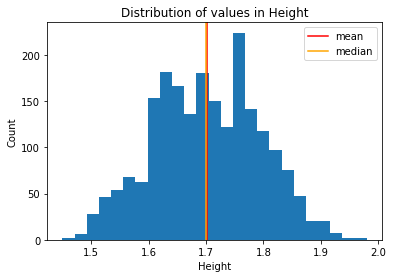

In [15]:
plot_distribution(obesity_data, "Height")

#### Weight

Weight does not offer interesting observations. Distribution is more or less bi-modal; the mean and the median are shifted to the left because of the larger number of people weighting 80 kg. 

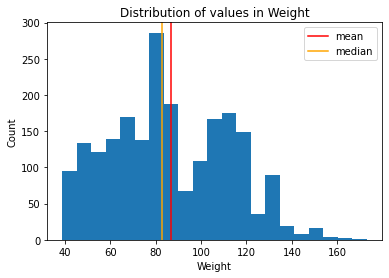

In [16]:
plot_distribution(obesity_data, "Weight")

It would be interesting to see if there is any relationship between "Height" and "Weight" since both metrics are used to compute `Body mass index`. Furthermore, these are the most important features (see Chapter V) for predicting if a person suffers from overweight/obesity.

The code line below plots each person's weight and height. The red line shows that there is a positive correlation between them, which means an increase in one variable leads to an increase in the other. In other words, taller people are more likely to weight more.

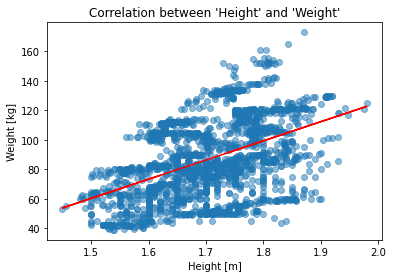

In [17]:
plt.scatter(obesity_data["Height"], obesity_data["Weight"], alpha = 0.5)
m, b = np.polyfit(obesity_data["Height"], obesity_data["Weight"], 1)
plt.plot(obesity_data["Height"], m * obesity_data["Height"] + b, color = "red")

plt.xlabel("Height [m]")
plt.ylabel("Weight [kg]")
plt.title("Correlation between 'Height' and 'Weight'")
plt.show()

#### Does overweight run in the family? 

People were asked if family members suffered from overweight. Most of them replied affirmative.

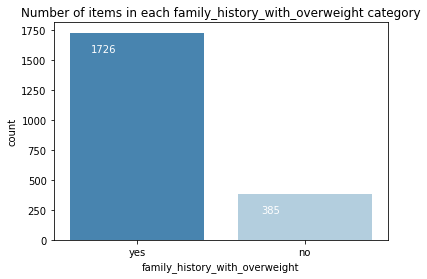

In [18]:
count_values(obesity_data, "family_history_with_overweight")

#### Consumption of high caloric food

Survey respondents had to say if they eat high caloric food frequenty. There were only two possible answers: "yes" or "no". Most of them (ca. 88%) admitted they consume high caloric food.

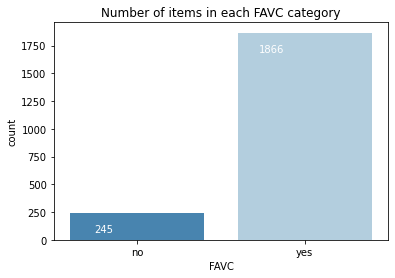

In [19]:
count_values(obesity_data, "FAVC")

#### Consumption of vegetables

"FCVC" column denotes if people consume vegetables. Possible answers were "Never", "Sometimes", and "Always". It is not clear why values are numeric and not categorical (discrete) ones. It could be assumed that "3" means "Always", "2" - "Sometimes", and "1" - "Never", but it is not clear what the values inbetween mean.

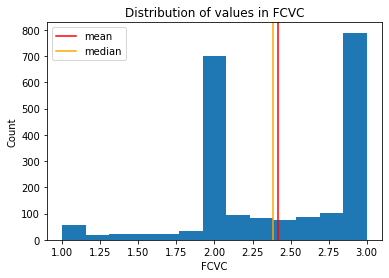

In [20]:
plot_distribution(obesity_data, "FCVC")

#### Meals per day

Similarly, repondents had to point the number of main meals they have daily: "Between 1 and 2",  "Three", and "More than three". Instead of categorical, this feature also holds numerical values. Mean and median are not informative here either.

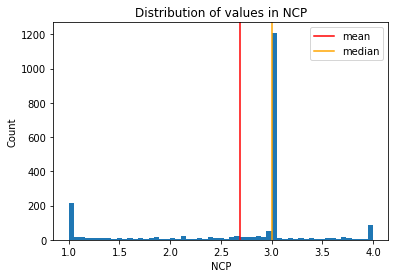

In [21]:
plot_distribution(obesity_data, "NCP")

#### Food between meals

People had to say if and how offen they eat between meals. They could answer eigher "No" (if they do not get bites between regular time for eating), or "Sometimes", "Frequently", or "Always". The data suggests that most people "sometimes" get small snacks between meals.

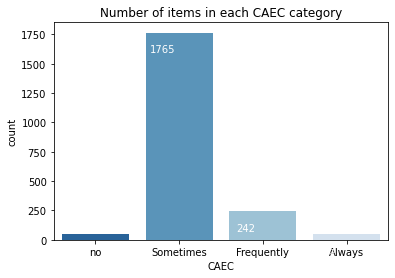

In [22]:
count_values(obesity_data, "CAEC", ["no", "Sometimes", "Frequently", "Always"])

#### Smoke

Most respondents do not smoke.

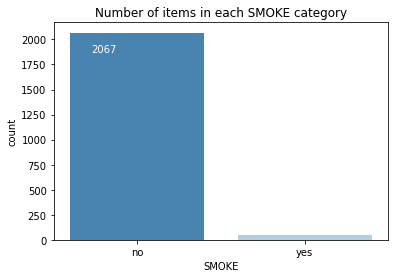

In [23]:
count_values(obesity_data, "SMOKE")

#### Drink water

Drinking water habits should have been categorised in three groups: "Less than a litter", "Between 1 and 2 L", and "More than 2 L". Instead, the answeres are entered as continuous values. Their distribution (not very informative, too) is shown below.

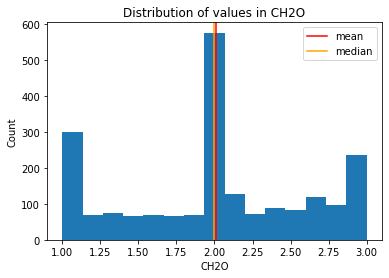

In [24]:
plot_distribution(obesity_data, "CH2O")

#### Monitor intake of calories 

It seems people do not worry about the calories they get daily. On the other hand, they might not have been aware of the nutritional value and ingredients of each food if these were not listed on the packing.

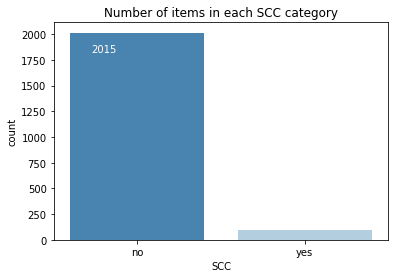

In [25]:
count_values(obesity_data, "SCC")

#### Physical activity

Respondents were asked to share their physical activity. They had to choose 1 out of 4 optional answers: "I do not have", "1 or 2 days", "2 or 4 days", and "4 or 5 days". Values in "FAF" column are continuous instead of categorical ones. These are plotted below but their distribution (as well as mean and median) are hard for interpretation.

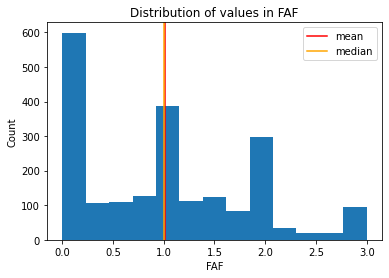

In [26]:
plot_distribution(obesity_data, "FAF")

#### Physical INactivity

Similarly, people were asked to state how much time they spend on using technological devices such as cell phone, videogames, television, computer, etc. They could say "0-2 hours", "3-5 hours", and "More than 5 hours". Responses are stored as continuous values. Their distribution, which could not be interepreted, is shown below.

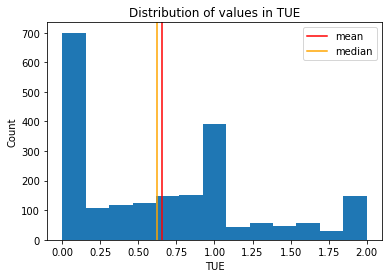

In [27]:
plot_distribution(obesity_data, "TUE")

#### Drink alcohol

Most people drink alcohol "sometimes", but almost a third claim they do not consume any alcoholic beverages.

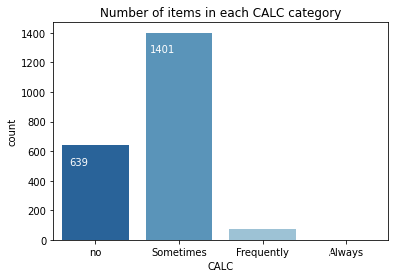

In [28]:
count_values(obesity_data, "CALC")

#### Transportation

Most people (around 3/4) rely on public transportation. Much fewer respondents use their cars. The remainder either commute or use a bike or motorbike.

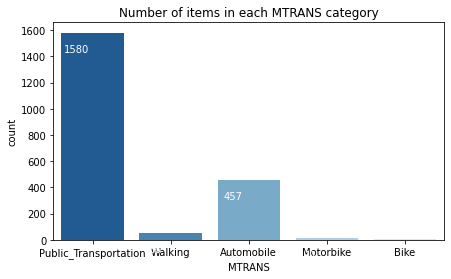

In [29]:
plt.figure(figsize = (7, 4))
count_values(obesity_data, "MTRANS")

#### Normal, Overweight or Obese?

People, according to their `Body mass index (BMI)`, are categorised as:

* Underweight if BMI < 18.5
* Normal if BMI 18.5 - 24.9 
* Overweight if BMI 25.0 - 29.9
* Obesity I if BMI 30.0 - 34.9
* Obesity II if BMI 35.0 to 39.9
* Obesity III if BMI > 40

Number of people per category is displayed below (note: categories are ordered logically).

The plot shows the dataset is balanced; only "Obese Type I" class slightly outnumber the other categories.

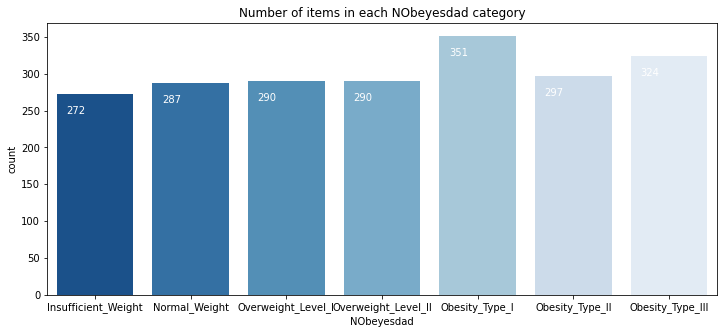

In [30]:
plt.figure(figsize = (12, 5))
count_values(obesity_data, "NObeyesdad", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]) 

##### Overweight and Gender

It is interesting to see how Overweight/Obesity interact with different categorical variables. The function below computes and plots this interaction.

In [31]:
def cross_plot(dataset, lead_category, sup_category, order = None):
    """
    Function: Plots interaction between two categorical variables.
    
    Parameters: Dataset, lead category, suplemental category, and order of appearance (order is optional).
    """
    
    sns.countplot(x = lead_category, hue = sup_category, data = dataset, order = order, palette = "Blues_r")
    
    plt.show()

Women are more likely to have "Insufficient weight" than men. On the other hand, there are more obese men than women, save in the last, extreme obesity category.

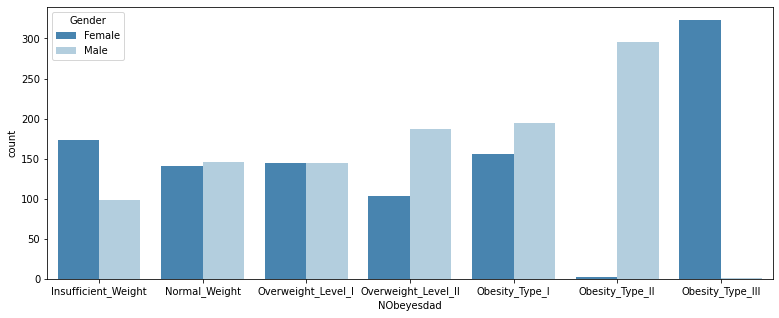

In [32]:
plt.figure(figsize = (13, 5))
cross_plot(obesity_data, "NObeyesdad", "Gender", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"])

##### Overweight and family history

It seems obesity runs in the family. All those categorised as overweight or obese had family members suffering from weight problems.

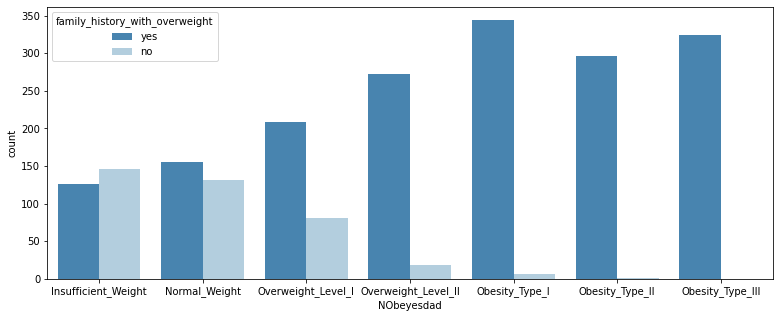

In [33]:
plt.figure(figsize = (13, 5))
cross_plot(obesity_data, "NObeyesdad", "family_history_with_overweight", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"])

##### Overweight and high calories food

Both normal weight and overweight/obese people consume high calories food. Perhaps food quantity makes the difference and affects body fats.

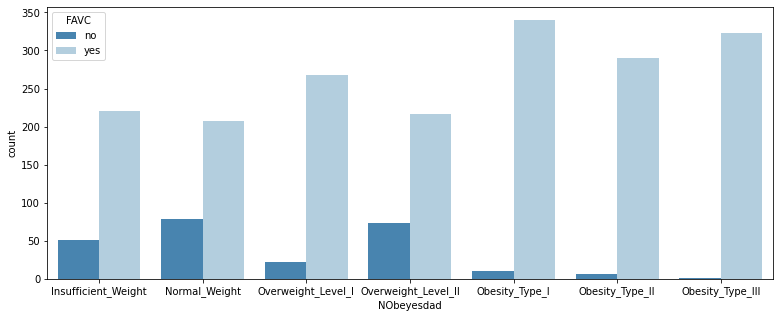

In [34]:
plt.figure(figsize = (13, 5))
cross_plot(obesity_data, "NObeyesdad", "FAVC", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]) 

##### Overweight and food between meals

Weight of those who "frequently" or "always" get food between meals does not seem to be abnormal. Only people having snaks from time to time go into "Overweight" or "Obesity" categories.

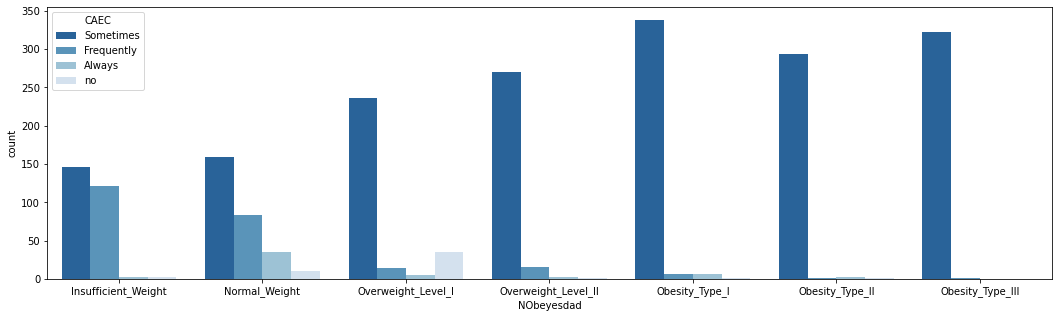

In [35]:
plt.figure(figsize = (18, 5))
cross_plot(obesity_data, "NObeyesdad", "CAEC", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]) 

##### Overweight and smoking

It seems smoking is not a predictor or does not affect body weight. There is a tiny number of smokers who could be both normal and overweight.

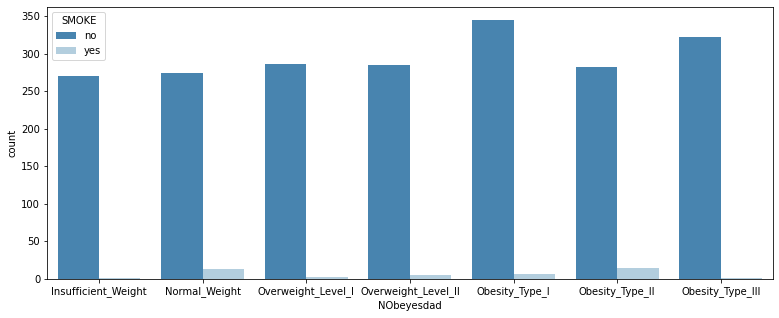

In [36]:
plt.figure(figsize = (13, 5))
cross_plot(obesity_data, "NObeyesdad", "SMOKE", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]) 

##### Overweight and monitoring calories

People who tend to monitor their calories intake are less likely to get excess weight.

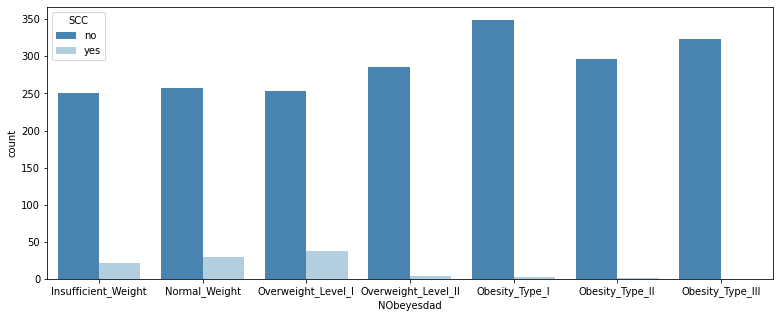

In [37]:
plt.figure(figsize = (13, 5))
cross_plot(obesity_data, "NObeyesdad", "SCC", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]) 

##### Overweight and alcohol

There might exist a weak link between alcohol and obesity. The data suggest that people who "sometimes" drink alcohol could face weight propblems.

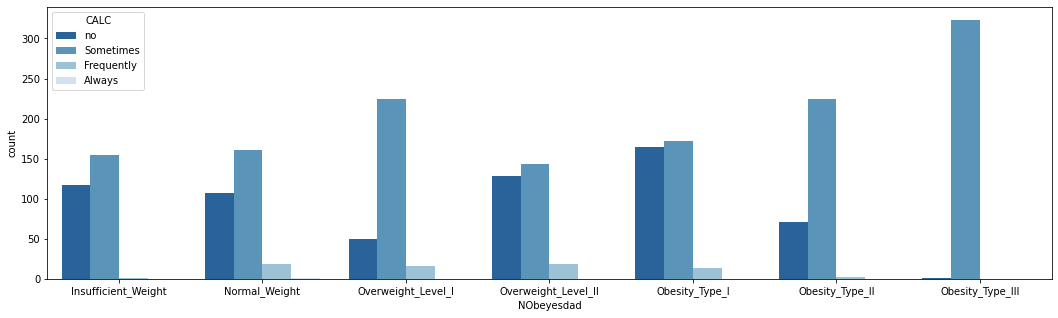

In [38]:
plt.figure(figsize = (18, 5))
cross_plot(obesity_data, "NObeyesdad", "CALC", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]) 

##### Overweight and means of transport

Transportation seems does not (significantly) affect a person's weight. Both slim, normal and overweight people use public transport; all groups rely on cars as well.

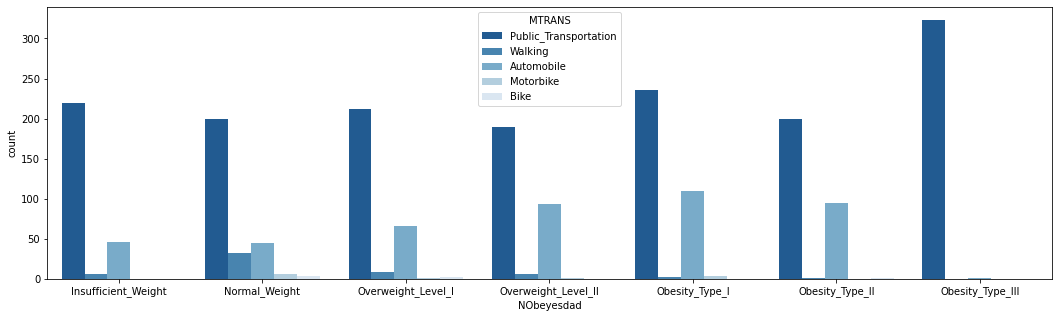

In [39]:
plt.figure(figsize = (18, 5))
cross_plot(obesity_data, "NObeyesdad", "MTRANS", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]) 

### II. 2. Explore Statistics

Five-number statistics does not reveal much information about features with numeric values. Data in most columns (except age, height and weight) are not interpretable. Nonetheless, these are displayed below.

In [40]:
obesity_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2111.0,24.312600,6.345968,14.00,19.947192,22.777890,26.000000,61.00
Height,2111.0,1.701677,0.093305,1.45,1.630000,1.700499,1.768464,1.98
Weight,2111.0,86.586058,26.191172,39.00,65.473343,83.000000,107.430682,173.00
FCVC,2111.0,2.419043,0.533927,1.00,2.000000,2.385502,3.000000,3.00
NCP,2111.0,2.685628,0.778039,1.00,2.658738,3.000000,3.000000,4.00
CH2O,2111.0,2.008011,0.612953,1.00,1.584812,2.000000,2.477420,3.00
FAF,2111.0,1.010298,0.850592,0.00,0.124505,1.000000,1.666678,3.00
TUE,2111.0,0.657866,0.608927,0.00,0.000000,0.625350,1.000000,2.00


In [41]:
obesity_numeric = obesity_data[["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]]

The boxplots below show quartiles and outliers. Distributions in the last 5 columns are not taken into account. 

The first boxplot suggests that there are outliers in the "Age" column. However, 40, 50 or 60 years of age are normal values (they are not extreme or errors) and for this reason these are not removed. "Height" does not seem to have outliers, and "Weight" has only a couple ones. These are not treated either.

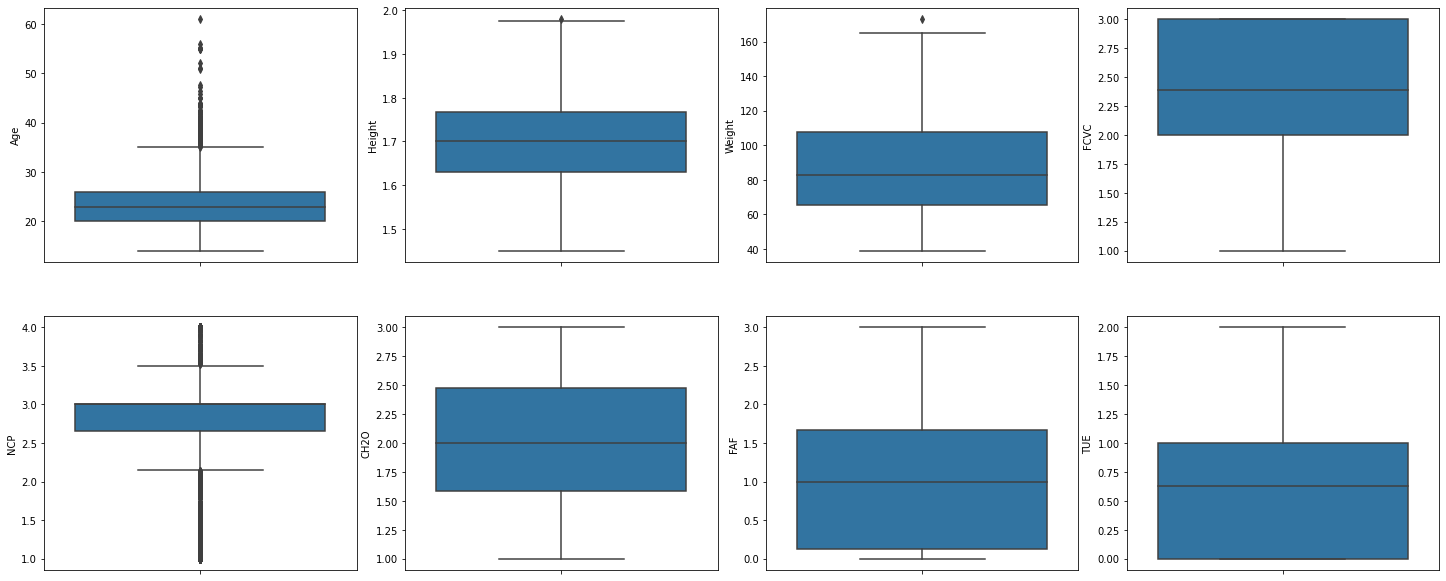

In [42]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (20, 8))
# fig.delaxes(axs[1][3])
idx = 0
axs = axs.flatten()
for k, v in obesity_numeric.items():
    sns.boxplot(y = k, data = obesity_numeric, ax = axs[idx])
    idx += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

(Linear) correlation between numeric features is weak or nonexistent. Thus, all features remain in the table.

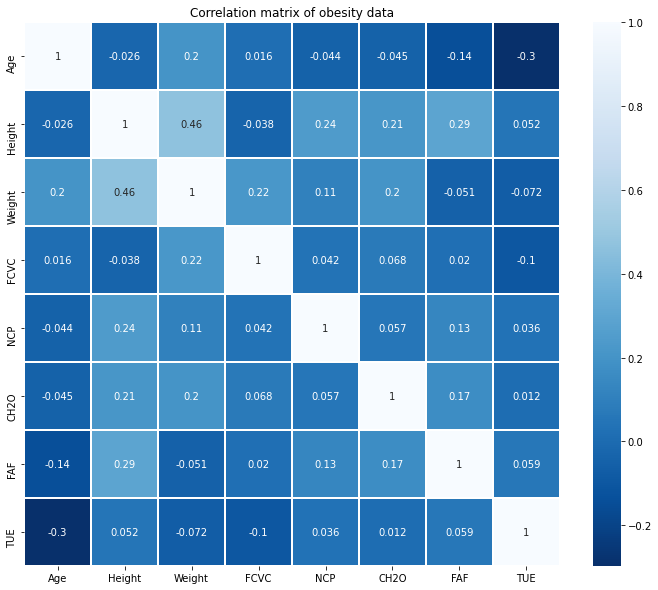

In [43]:
plt.figure(figsize = (12, 10))
sns.heatmap(obesity_data.corr(),
           annot = True,
           cmap = "Blues_r",
           linewidths = 2, 
           linecolor = "white")
plt.title("Correlation matrix of obesity data")
plt.show()

## III. Data pre-processing
### III.1. Encoding Features

Categorical variables are one-hot encoded with `get_dummies()`. Labels (i.e., the column holding information if a person is overweight/obese or not) are stored in separate variable; it will be used later.

In [44]:
obesity_dummies = pd.get_dummies(obesity_data[["Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]])

In [45]:
obesity_lab = obesity_data[["NObeyesdad"]]

All three sets - numeric features, one-hot encoded ones, and labels are concatenated in a new DataFrame. It has 32 columns now. Its head rows are displayed below. 

In [46]:
obesity_concatenated = pd.concat([obesity_numeric, obesity_dummies, obesity_lab], axis = 1)

In [47]:
obesity_concatenated.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,1,0,...,0,0,0,1,0,0,0,1,0,Normal_Weight
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,1,0,...,0,0,1,0,0,0,0,1,0,Normal_Weight
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,0,1,...,0,1,0,0,0,0,0,1,0,Normal_Weight
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,0,1,...,0,1,0,0,0,0,0,0,1,Overweight_Level_I
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,0,1,...,0,0,1,0,0,0,0,1,0,Overweight_Level_II


### III.2 Separate Features and Labels

Features and labels are separated and stored in different variables.

In [48]:
obesity_label = obesity_concatenated["NObeyesdad"]
obesity_features = obesity_concatenated.drop("NObeyesdad", axis = 1)

In [49]:
obesity_label

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object

### III.3 Convert Numerical Values

A brief check shows that some columns hold "float64" numbers, and another - "uint8" values. Machine Learning algorithms work best with floating point numbers. For this reason, all values are converted into floats.

In [50]:
obesity_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   Weight                              2111 non-null   float64
 3   FCVC                                2111 non-null   float64
 4   NCP                                 2111 non-null   float64
 5   CH2O                                2111 non-null   float64
 6   FAF                                 2111 non-null   float64
 7   TUE                                 2111 non-null   float64
 8   Gender_Female                       2111 non-null   uint8  
 9   Gender_Male                         2111 non-null   uint8  
 10  family_history_with_overweight_no   2111 non-null   uint8  
 11  family_history_with_overweight_yes  2111 no

In [51]:
obesity_features = obesity_features.astype("float")

The code line below confirms the features hold only "float64" numbers now.

In [52]:
obesity_features.dtypes

Age                                   float64
Height                                float64
Weight                                float64
FCVC                                  float64
NCP                                   float64
CH2O                                  float64
FAF                                   float64
TUE                                   float64
Gender_Female                         float64
Gender_Male                           float64
family_history_with_overweight_no     float64
family_history_with_overweight_yes    float64
FAVC_no                               float64
FAVC_yes                              float64
CAEC_Always                           float64
CAEC_Frequently                       float64
CAEC_Sometimes                        float64
CAEC_no                               float64
SMOKE_no                              float64
SMOKE_yes                             float64
SCC_no                                float64
SCC_yes                           

### III.4 Scale Features

Values in all features should be in the same range. Otherwise, the algorithm might misinterpret and assign them wrong coefficients (weights). Obesity features are scaled with `MinMaxScaler()` which makes all values between 0 and 1. The second row confirms the scaling was successful.

In [53]:
obesity_features_scaled = MinMaxScaler().fit_transform(obesity_features)

In [54]:
obesity_features_scaled.min(axis = 1), obesity_features_scaled.max(axis = 1)

(array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]))

### III.5 Encode Labels

Most Machine Learning classification algorithms expect labels with numeric values (and not strings). For this reason, obesity class is encoded with `LabelEncoder()`. The latter replaces each class with an integer. 

First, the encoder is instantiated. Then, it "overviews" the data. `transform()` encodes the classes and assigns them the respective number.

In [55]:
encoder = LabelEncoder()

In [56]:
encoder.fit(obesity_label)

LabelEncoder()

In [57]:
list(encoder.classes_)

['Insufficient_Weight',
 'Normal_Weight',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III',
 'Overweight_Level_I',
 'Overweight_Level_II']

In [58]:
obesity_labels_encoded = encoder.transform(obesity_label)

In [59]:
obesity_labels_encoded

array([1, 1, 1, ..., 4, 4, 4])

### III.6 Train - Test split

The dataset is split into training and testing sets. A validation set was not withheld since the dataset is small and sufficient number of samples should be kept for training. Cross validation during Grid Search addresses this drawback. 

Splitting function (`train_test_split`) shuffles the data and reserves 20% for testing. Datasets' shape after splitting is checked below.

In [60]:
obesity_features_tr, obesity_features_ts, obesity_labels_tr, obesity_labels_ts = train_test_split(
                obesity_features, obesity_labels_encoded, 
                test_size = 0.2, stratify = obesity_labels_encoded,
                random_state = 42) # shuffle=True

In [61]:
obesity_features_tr.shape, obesity_labels_tr.shape, obesity_features_ts.shape, obesity_labels_ts.shape

((1688, 31), (1688,), (423, 31), (423,))

`Counter` tells how many examples are placed in each class. The outputs below show that there are sufficient number of samples both in training and testing set. 

In [62]:
Counter(obesity_labels_tr)

Counter({5: 232, 1: 229, 6: 232, 0: 218, 3: 237, 4: 259, 2: 281})

In [63]:
Counter(obesity_labels_ts)

Counter({0: 54, 1: 58, 6: 58, 4: 65, 3: 60, 2: 70, 5: 58})

## IV. Train model to classify data into obesity categories

The first modelling task is to classify data into obesity categories. "Accuracy" is a good performance metric but "f1 score" (geometric mean of "precision" and "recall") is a more appropriate one. To use it for grid search and cross validation, it is instantiated as a variable. 

It could be assumed that many classifiers would return good scores. `DecisionTreeClassifier()` is chosen for its simplicity and interpretability. It has several hyper-parameters, which could be tuned but only tree's depth was used.

`RandomSearchCV()` checks which combination returns best results. The grid space is limited between 5 and 15 tree nodes (questions). These are stored in a dictionary, which is passed to for searching. Models are trained and cross-validated on 5 folds.

### IV. 1 Build Model

In [64]:
f1 = make_scorer(f1_score, average = "weighted")

In [65]:
params = {
    "max_depth": [5, 7, 9, 11, 13, 15]
}

In [66]:
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid = params, cv = 5, scoring = f1)

In [67]:
grid_search.fit(obesity_features_tr, obesity_labels_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 7, 9, 11, 13, 15]},
             scoring=make_scorer(f1_score, average=weighted))

Cross-validation shows that almost all combinations reach "f1 score" close to or above 90%. 

In [68]:
grid_search.cv_results_

{'mean_fit_time': array([0.00841069, 0.00896721, 0.00965266, 0.00976419, 0.00990853,
        0.0097033 ]),
 'std_fit_time': array([1.14697676e-03, 9.41514214e-05, 1.45189938e-04, 1.73734557e-04,
        2.04081435e-04, 7.97902034e-05]),
 'mean_score_time': array([0.00302353, 0.00293074, 0.00296116, 0.00296593, 0.00303864,
        0.00293608]),
 'std_score_time': array([1.29918709e-04, 3.51848313e-05, 4.56388215e-05, 7.45343916e-05,
        6.56899218e-05, 4.57767149e-05]),
 'param_max_depth': masked_array(data=[5, 7, 9, 11, 13, 15],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5},
  {'max_depth': 7},
  {'max_depth': 9},
  {'max_depth': 11},
  {'max_depth': 13},
  {'max_depth': 15}],
 'split0_test_score': array([0.77448113, 0.87609124, 0.91320203, 0.90543249, 0.90496149,
        0.91123085]),
 'split1_test_score': array([0.82389405, 0.91253235, 0.94125661, 0.94108256, 0.93833224,
        0.93

The best model is a tree with 13 nodes (questions). Therefore, this value is set as a hyper-parameter. 

In [69]:
grid_search.best_params_

{'max_depth': 13}

### IV. 2. Train and Evaluate Model

In [70]:
model_tree = DecisionTreeClassifier(max_depth = 13, random_state = 42)

For clarity, `fit`, `predict`, and `score` are placed in a function, which facilitates model training, evaluation and selection. In this particular case it will only print Decision Tree's preformance in terms of its "accuracy" and "f1 score" on both sets. 

In [71]:
def train_predict_score(estimator, train_features, train_labels, test_features, test_labels):
    """
    Function: Trains model, predict classes and computes accuracy and f1 score.
    
    Parameters: estimator, X_train, y_train, X_test, y_test.
    """
    estimator.fit(train_features, train_labels)
    
    print(f"Accuracy on Train data: {accuracy_score(train_labels, estimator.predict(train_features))}")
    print(f"F1 score on Train data: {f1_score(train_labels, estimator.predict(train_features), average = 'weighted')}")
    print(f"Accuracy on Test data: {accuracy_score(test_labels, estimator.predict(test_features))}")
    print(f"F1 on Test data: {f1_score(test_labels, estimator.predict(test_features), average = 'weighted')}")

Both "accuracy" and "f1 score" on the training data are 100% but on the testing one is 91%-92%. The latter suggests the model is overfitting. Its performance could be improved either with regularization (e.g., shallower tree, setting minimum samples per leaf), or with feature selection (e.g., removing non-important columns), or with increasing the number of samples in both sets. Neither of these techniques is explored further since "accuracy" and "f1 score" over 90% is not so disappointing.

In [72]:
train_predict_score(model_tree, obesity_features_tr, obesity_labels_tr, obesity_features_ts, obesity_labels_ts)

Accuracy on Train data: 1.0
F1 score on Train data: 1.0
Accuracy on Test data: 0.9148936170212766
F1 on Test data: 0.9152724912457364


Decision trees are easier to interpret. If plotted (see below), they show how decisions were taken (i.e., how classification happened). Each node "asks" a question; if the response is "True", the information is transmitted to the child node on the left; if it is "False", information goes to the child on the right. This process continues either until no more questions could be asked, or until reaching "max_depth" limit. Only the first 2 nodes are displayed below.

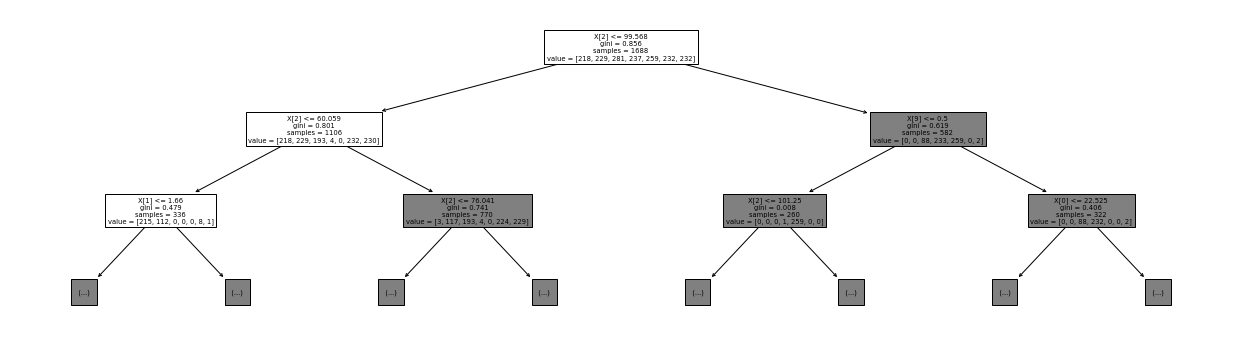

In [73]:
plt.figure(figsize = (22, 6))
plot_tree(model_tree, max_depth = 2)
plt.show()

##### Classification Report

`classification_report` is a `scikit learn` function which shows classification success (metrics) for each class. For example, most of the samples in "Obesity_Type_III" (class 4) were properly classified. The model reached 100% "precision" and 99% "f1 score". On the other hand, features indicating "Normal_Weight" (class 1) were wrongly interpreted and got around 80% on "precision" and "f1 score". 

In [74]:
print(classification_report(obesity_labels_ts, model_tree.predict(obesity_features_ts)))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        54
           1       0.80      0.84      0.82        58
           2       0.91      0.96      0.93        70
           3       0.97      0.95      0.96        60
           4       1.00      0.98      0.99        65
           5       0.86      0.86      0.86        58
           6       0.91      0.91      0.91        58

    accuracy                           0.91       423
   macro avg       0.92      0.91      0.91       423
weighted avg       0.92      0.91      0.92       423



In [75]:
model_tree.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [76]:
list(encoder.classes_)

['Insufficient_Weight',
 'Normal_Weight',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III',
 'Overweight_Level_I',
 'Overweight_Level_II']

##### Confusion Matrix

`confusion_matrix` shows *actual* vs *predicted* labels. Rows represent actual classes, while columns represent predicted classes. For example, 47 samples were properly classified in the 0-th class but 7 were wrongly placed in 1-st class. Only one sample of class 4 was misclassified as a sample of class 3.

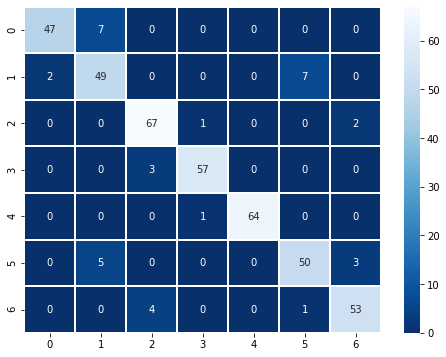

In [77]:
plt.figure(figsize = (8, 6))
sns.heatmap(confusion_matrix(obesity_labels_ts, model_tree.predict(obesity_features_ts)),
           annot = True,
           fmt = ".0f",
           cmap = "Blues_r",
           linewidths = 2, 
           linecolor = "white",
           xticklabels = model_tree.classes_,
           yticklabels = model_tree.classes_)
plt.show()

##### ROC Score and Curve

Another popular classification metric is the ROC curve (Receiver Operating Characteristic curve). It is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate and False Positive Rate. Area Under the Curve (AUC) represents the probability that a random positive example is positioned to the right of a random negative example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.

AUC and ROC curve require computing probability prediction scores. These show the probability a certain sample belongs to a particular class.

In [78]:
obesity_score_probability = model_tree.predict_proba(obesity_features_ts)

The first sample has the highest probability of being 0-th class, the second - 1-st class, and so forth.

In [79]:
obesity_score_probability

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

Aggregated AUC score for all classes (computed as "One vs Rest") is around 95%. This is not so bad performance.

In [80]:
roc_auc_score(obesity_labels_ts, obesity_score_probability, multi_class = "ovr")

0.948826099443833

ROC Curves are ploted below. They climb up and to the left, which indicates a good model performance. As found earlier, the model best predicts class 4 (light green line), class 6 (red line) and class 0 (black line). AUCs for all classes are displayed on the legend.

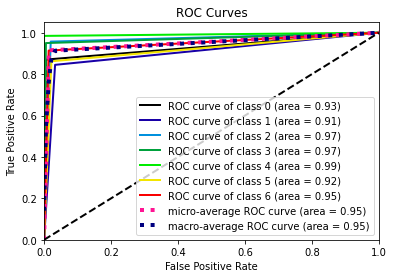

In [82]:
skplt.metrics.plot_roc(obesity_labels_ts, obesity_score_probability)
plt.show()

## V. Clustering 

An experiment was made to use dataset's features clustering. Forming separate clusters would indicate that values for the given features are specific for particular overweight/obesity type. The task is performed with "KMeans" - the simplest clustering algorithm. Instantiating requires setting the number of clusters to form, as well as the number of centroids to generate. Number of clusters is known: 7, for each weight type. "K-means++" is the chosen method for initialization - it selects initial cluster centers in a smart way to speed up convergence.

In [83]:
kmeans = KMeans(n_clusters = 7, init = "k-means++")

Features and their projection should be visualized to show how clustering works. However, displaying more than 3 dimensions on a 2D surface is impossible. For this reason, only the most important features (i.e., those holding the most valuable information) are shown. `DecisionTreeClassifier()` found that the second ("Height") and the third ("Weight") columns are the most important ones. They bear 21.9% and 47.85%, respectively, of the information in the data. The output below also shows that values in some columns were not beneficial for revealing their relationship with obesity and could have been removed.

In [84]:
model_tree.feature_importances_

array([0.04184926, 0.22082785, 0.47515547, 0.0135702 , 0.00714488,
       0.00561014, 0.00081335, 0.01124707, 0.00060059, 0.15732823,
       0.0006524 , 0.00232294, 0.02176254, 0.00069194, 0.00134318,
       0.00157633, 0.00760256, 0.        , 0.        , 0.00135428,
       0.        , 0.        , 0.        , 0.        , 0.00062654,
       0.02540261, 0.00251765, 0.        , 0.        , 0.        ,
       0.        ])

Clusters (formed by "Height" and "Weight" features) in the testing data according to their real labels are plotted below. 

In [85]:
def plot_clusters(dataset, feature_one, feature_two, labels, title = None):
    """
    Function: Computes and displays clusters.
    
    Parameters: dataset, 2 features, cluster indicator.
    """
    sns.scatterplot(data = dataset, x = feature_one, y = feature_two, hue = labels, palette = "Blues_r")
    if title is not None:
        plt.title(title)
    plt.show()

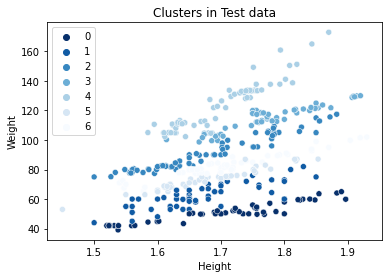

In [86]:
plot_clusters(obesity_features_ts, "Height", "Weight", obesity_labels_ts, "Clusters in Test data")

`KMeans` computes the distances between each point (described by feature values) and assigns it to a cluster. Thus, clustering could be considered an unsupervised learning classification tool (algorithm). However, its performance could not assessed since there are not evaluation metrics for unsuprevised training. 

In [87]:
predicted_labels = kmeans.fit_predict(obesity_features_ts)

Classes on both plots differ since the clustering algorithm does not know how to order them (i.e., which predicted values correspond to class 0, which - to class 1, etc.). Nonetheless, KMeans managed to group "Height" and "Weight" points in 7 categories which very much overlap the testing labels.

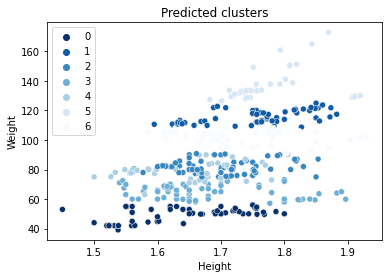

In [88]:
plot_clusters(obesity_features_ts, "Height", "Weight", predicted_labels, "Predicted clusters")

## Conclusion

A person's height and weight are the most important factors determining his/her obesity status. Other factors might also play a role, e.g., eating habits and physical activity. Dataset features could be used both for classification and clustering tasks but it should be borne in mind that most samples are synthetically generated, i.e., they do not reflect the real world. Thus, robust conclusions require much more data representative for larger groups.

## References:

[1] Palechor, F. M., & de la Hoz Manotas, A. (2019). Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico. Data in Brief, 104344.